# Probabilistic Machine Learning
Annalisa Paladino

## Set Environment

In [1]:
# General
import os
from tqdm.auto import tqdm

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Set seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Data Loading

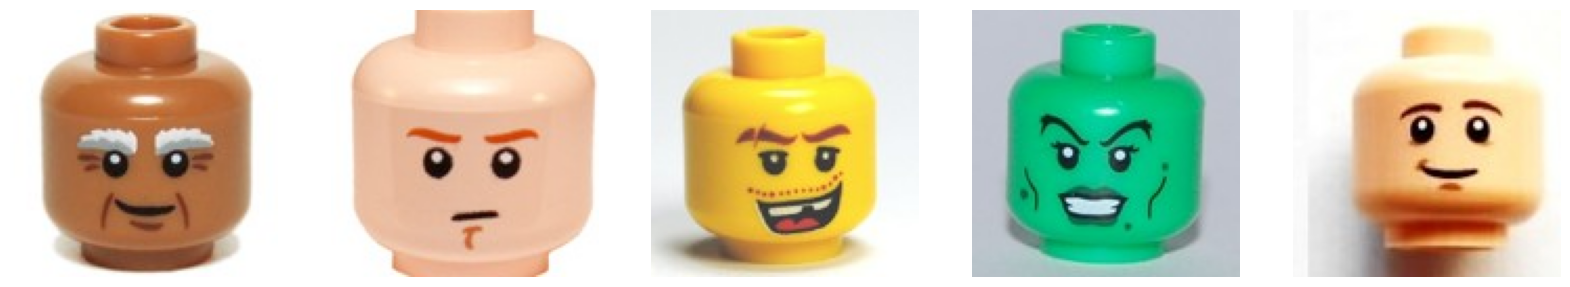

In [2]:
from utils import FacesDataset

# Load dataset
images = [ 'dataset/'+str(file) for file in os.listdir('dataset') if file.endswith('.jpg')]
faces_dataset = FacesDataset(images)

# Show some images
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image, _ = faces_dataset[i]
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].axis('off')
plt.show()

In [3]:
TRAIN_SIZE = 0.8
train_dataset, test_dataset = train_test_split(faces_dataset, train_size=TRAIN_SIZE, random_state=SEED)
train_dataset, val_dataset = train_test_split(train_dataset, train_size=TRAIN_SIZE, random_state=SEED)

In [4]:
# Dataloaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [5]:
from models import VAE

## Training

### Hyperparameters Tuning - Bayesian Optimization

Bayesian optimization is typically used on problems of the form 
$$\max_{x \in A} f(x)$$
where $A$ is a set of points $x$ that maximize a function $f(x)$.

Bayesian optimization has 2 primary components: a **surrogate model**, a method for statistical inference (typically Gaussian process GP regression), to approximate the expensive-to-evaluate objective function f(x) and an **acquisition function** (typically Expected Improvement) to guide where to sample next. 

*Algorithm:*

Place a Gaussian process prior on $f$

Observe $f$ at $n_0$ points according to an initial space-filling experimental design. Set $n=n_0$ 

While $n \le N$ do

- Update the posterior probability distribution on $f$ using all available data

- Let $x_n$ be a maximizer of the acquisition function over $x$, where the acquisition 	function is computed using the current posterior distribution

- Observe $y_n = f(x_n)$

- Increment $n$

End while

Return the point evaluated with the largest $f(x)$


In [6]:
from utils import ht_function

ht_function_wrapper = lambda hidden_dim, latent_dim: -1*ht_function(
    train_loader=train_loader,
    val_loader=val_loader,
    model_class=VAE,
    model_params={
        'latent_dim' : latent_dim,
        'hidden_dim' : hidden_dim,
        'dropout_rate' : 0.05
    },
    training_params={
        'n_epochs' : 50,
        'initial_lr' : 1e-3,
        'end_lr' : 1e-4,
        'clip_grad_value' : 1.0,
    },
    device=device,
)

In [7]:
from bayes_opt import BayesianOptimization

# Bound of the hyperparameters
pbounds = {
    'hidden_dim': (128, 2048),
    'latent_dim': (8, 64),
}

bayesian_optimizer = BayesianOptimization(
    f=ht_function_wrapper,
    pbounds=pbounds,
    random_state=SEED,
    verbose=2,
)

In [8]:
from time import time

random_samples = 10
exploiting_samples = 90

t0 = time()
bayesian_optimizer.maximize(init_points=random_samples, n_iter=exploiting_samples)
tf = time()

elapsed_time = tf - t0
print(f"Bayesian optimization took {elapsed_time:.2f} seconds.")

|   iter    |  target   | hidden... | latent... |
-------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

| 1         | -1.178e+0 | 847.1     | 61.24     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 2         | -1.134e+0 | 1.533e+03 | 41.52     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 3         | -1.073e+0 | 427.6     | 16.74     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 4         | -1.21e+03 | 239.5     | 56.51     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 5         | -1.109e+0 | 1.282e+03 | 47.65     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 6         | -1.176e+0 | 167.5     | 62.31     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 7         | -1.11e+03 | 1.726e+03 | 19.89     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 8         | -1.147e+0 | 477.1     | 18.27     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 9         | -1.198e+0 | 712.1     | 37.39     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 10        | -1.13e+03 | 957.3     | 24.31     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 11        | -1.033e+0 | 436.4     | 18.42     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 12        | -1.096e+0 | 435.8     | 17.85     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 13        | -1.047e+0 | 428.5     | 16.85     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 14        | -1.106e+0 | 437.1     | 19.12     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 15        | -1.087e+0 | 428.2     | 17.7      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 16        | -1e+03    | 426.4     | 17.64     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 17        | -1.062e+0 | 425.8     | 17.21     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 18        | -1.131e+0 | 429.0     | 15.95     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 19        | -1.166e+0 | 429.3     | 17.33     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 20        | -1.113e+0 | 1.161e+03 | 26.16     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 21        | -1.018e+0 | 427.0     | 17.66     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 22        | -1.153e+0 | 426.5     | 18.31     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 23        | -1.109e+0 | 911.7     | 18.4      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 24        | -1.116e+0 | 979.3     | 30.17     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 25        | -1.186e+0 | 889.7     | 26.52     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 26        | -1.054e+0 | 893.6     | 27.65     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 27        | -1.132e+0 | 1.552e+03 | 13.24     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 28        | -1.18e+03 | 1.193e+03 | 58.41     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 29        | -1.099e+0 | 246.5     | 56.24     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 30        | -1.16e+03 | 436.0     | 18.8      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 31        | -1.122e+0 | 426.5     | 17.68     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 32        | -1.321e+0 | 1.514e+03 | 13.9      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 33        | -1.132e+0 | 889.0     | 38.91     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 34        | -1.091e+0 | 309.0     | 13.29     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 35        | -1.035e+0 | 1.795e+03 | 24.65     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 36        | -1.158e+0 | 885.0     | 45.76     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 37        | -1.177e+0 | 1.959e+03 | 45.84     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 38        | -1.184e+0 | 2.003e+03 | 40.97     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 39        | -1.302e+0 | 1.282e+03 | 47.79     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 40        | -1.101e+0 | 1.52e+03  | 29.13     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 41        | -1.198e+0 | 1.726e+03 | 19.85     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 42        | -1.055e+0 | 1.768e+03 | 10.45     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 43        | -1.15e+03 | 1.629e+03 | 45.12     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 44        | -1.091e+0 | 419.6     | 34.89     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 45        | -1.276e+0 | 2.004e+03 | 13.64     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 46        | -1.156e+0 | 1.653e+03 | 47.46     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 47        | -1.006e+0 | 933.0     | 57.43     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 48        | -1.243e+0 | 653.2     | 16.96     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 49        | -1.119e+0 | 1.121e+03 | 39.33     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 50        | -1.164e+0 | 1.008e+03 | 47.32     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 51        | -1.163e+0 | 1.297e+03 | 27.91     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 52        | -1.051e+0 | 523.2     | 47.93     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 53        | -1.041e+0 | 604.4     | 11.37     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 54        | -1.184e+0 | 618.1     | 51.85     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 55        | -1.159e+0 | 2.035e+03 | 58.28     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 56        | -1.194e+0 | 591.1     | 45.79     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 57        | -1.264e+0 | 1.829e+03 | 35.9      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 58        | -1.102e+0 | 1.522e+03 | 17.6      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 59        | -1.081e+0 | 351.4     | 43.09     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 60        | -1.163e+0 | 837.7     | 20.94     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 61        | -1.2e+03  | 349.1     | 35.29     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 62        | -1.032e+0 | 960.5     | 14.3      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 63        | -1.15e+03 | 1.008e+03 | 11.44     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 64        | -1.17e+03 | 1.614e+03 | 17.93     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 65        | -1.199e+0 | 999.6     | 54.56     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 66        | -1.101e+0 | 1.859e+03 | 51.61     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 67        | -1.051e+0 | 889.6     | 60.64     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 68        | -1.042e+0 | 589.2     | 40.21     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 69        | -1.161e+0 | 631.3     | 47.01     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 70        | -1.366e+0 | 1.85e+03  | 20.06     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 71        | -1.268e+0 | 1.071e+03 | 54.09     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 72        | -1.051e+0 | 1.531e+03 | 30.1      |


  0%|          | 0/50 [00:00<?, ?it/s]

| 73        | -1.151e+0 | 1.946e+03 | 26.14     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 74        | -1.062e+0 | 692.4     | 17.46     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 75        | -1.159e+0 | 1.775e+03 | 37.43     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 76        | -1.085e+0 | 314.3     | 59.32     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 77        | -1.142e+0 | 736.4     | 50.61     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 78        | -1.095e+0 | 1.58e+03  | 32.36     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 79        | -1.107e+0 | 1.294e+03 | 33.52     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 80        | -1.185e+0 | 161.6     | 50.07     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 81        | -1.132e+0 | 1.419e+03 | 11.95     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 82        | -1.224e+0 | 1.119e+03 | 58.67     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 83        | -1.19e+03 | 240.6     | 57.29     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 84        | -1.054e+0 | 1.1e+03   | 12.44     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 85        | -1.105e+0 | 464.4     | 18.03     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 86        | -1.055e+0 | 566.4     | 36.16     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 87        | -1.106e+0 | 1.043e+03 | 61.18     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 88        | -1.14e+03 | 710.2     | 61.87     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 89        | -1.222e+0 | 1.064e+03 | 55.27     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 90        | -1.114e+0 | 1.853e+03 | 50.51     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 91        | -1.15e+03 | 1.26e+03  | 10.35     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 92        | -1.09e+03 | 513.9     | 49.95     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 93        | -1.13e+03 | 642.3     | 53.89     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 94        | -1.169e+0 | 983.1     | 32.84     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 95        | -1.121e+0 | 1.277e+03 | 17.72     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 96        | -1.143e+0 | 166.9     | 54.21     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 97        | -1.119e+0 | 426.7     | 17.15     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 98        | -1.118e+0 | 611.1     | 28.99     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 99        | -1.108e+0 | 508.0     | 24.38     |


  0%|          | 0/50 [00:00<?, ?it/s]

| 100       | -1.218e+0 | 209.6     | 48.9      |
Bayesian optimization took 1040.23 seconds.


In [9]:
from tabulate import tabulate

# Best hyperparameters
table = tabulate(
    headers = ['Target', 'Hidden dim', 'Latent dim'],
    tabular_data = [
        ['Maximize', round(bayesian_optimizer.max['target'],1), round(bayesian_optimizer.max['params']['hidden_dim']), round(bayesian_optimizer.max['params']['latent_dim'])]
    ],
    tablefmt='pretty'
)
print(table)

+----------+---------+------------+------------+
|          | Target  | Hidden dim | Latent dim |
+----------+---------+------------+------------+
| Maximize | -1000.3 |    426     |     18     |
+----------+---------+------------+------------+


In [10]:
# All the results from the optimization process
ht_space = np.array([ [ round(iteration['params']['hidden_dim']), round(iteration['params']['latent_dim']) , iteration['target']] for iteration in bayesian_optimizer.res ])
ht_space_df = pd.DataFrame(ht_space, columns=['hidden_dim', 'latent_dim', 'target'])

#### Hyperparameters evolution

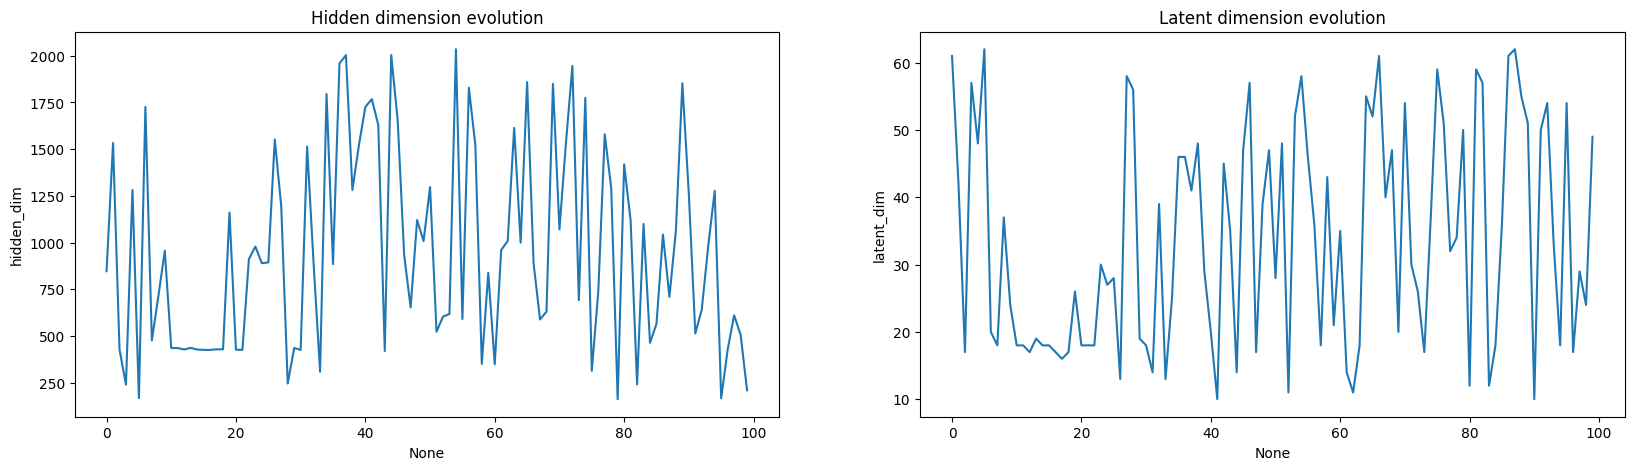

In [11]:
# Plot of the evolution in time of the hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(data=ht_space_df, x=ht_space_df.index, y='hidden_dim', ax=axs[0])
axs[0].set_title('Hidden dimension evolution')
sns.lineplot(data=ht_space_df, x=ht_space_df.index, y='latent_dim', ax=axs[1])
axs[1].set_title('Latent dimension evolution')
plt.show()

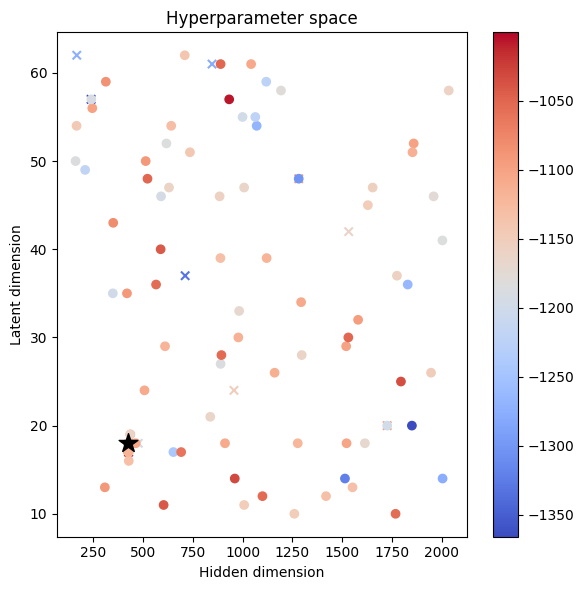

In [12]:
# Plot of the ht space
fig, ax = plt.subplots(figsize=(6, 6))
# The fist random_samples points are shown with a cross
ax = plt.scatter(
    ht_space_df.iloc[:random_samples]['hidden_dim'],
    ht_space_df.iloc[:random_samples]['latent_dim'],
    c=ht_space_df.iloc[:random_samples]['target'],
    cmap='coolwarm',
    marker='x'
)
# The exploiting_samples points are shown with a circle
ax = plt.scatter(
    ht_space_df.iloc[random_samples:]['hidden_dim'],
    ht_space_df.iloc[random_samples:]['latent_dim'],
    c=ht_space_df.iloc[random_samples:]['target'],
    cmap='coolwarm',
    marker='o',
)
# The best point is shown with a star
best_point = ht_space_df.iloc[ht_space_df['target'].idxmax()]
plt.scatter(best_point['hidden_dim'], best_point['latent_dim'], c='black', marker='*', s=200)
plt.colorbar(ax)
plt.xlabel('Hidden dimension')
plt.ylabel('Latent dimension')
plt.title('Hyperparameter space')
plt.tight_layout()
plt.show()

### Training best model

In [13]:
best_model_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=best_model_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_model_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_model_batch_size, shuffle=False)

In [14]:
best_hidden_dim = round(bayesian_optimizer.max['params']['hidden_dim'])
best_latent_dim = round(bayesian_optimizer.max['params']['latent_dim'])

model = VAE(latent_dim=best_latent_dim, hidden_dim=best_hidden_dim, dropout_rate=0.05)
model = model.to(device)
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 10440119


In [15]:
from utils import train_model

train_losses, val_losses, model = train_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    n_epochs=400,
    initial_lr=1e-3,
    end_lr=5e-7,
    clip_grad_value=1.0,
    device=device,
)

  0%|          | 0/400 [00:00<?, ?it/s]

Train loss: 429.3
Val loss: 1108.3


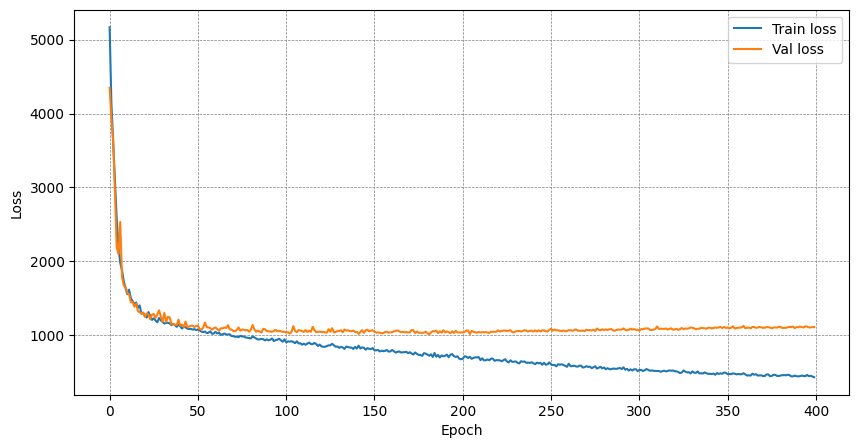

In [16]:
print('Train loss:', round(train_losses[-1], 1))
print('Val loss:', round(val_losses[-1], 1))

# Plot of the train and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid( linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.show()

## Sampling

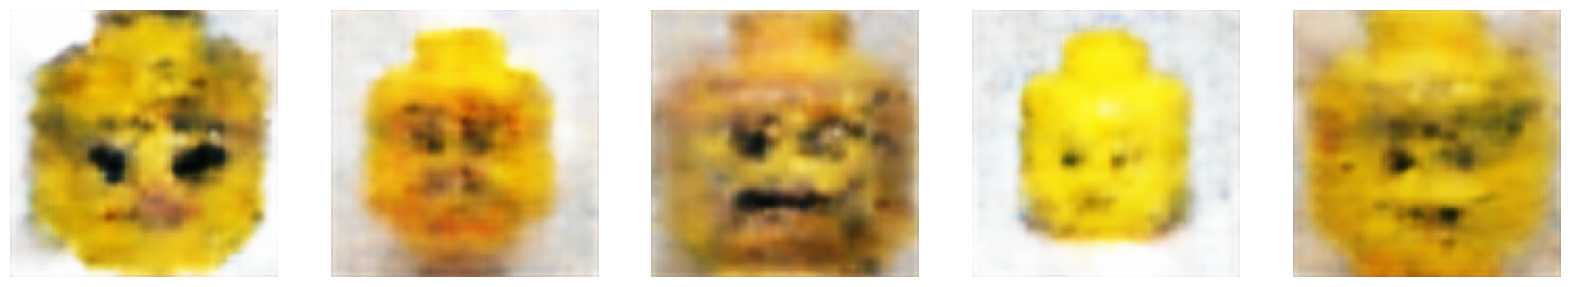

In [17]:
model.eval()
with torch.no_grad():
    z = torch.randn(10, best_latent_dim).to(device)
    samples = model.decode(z).cpu().permute(0, 2, 3, 1).numpy()
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        axs[i].imshow(samples[i])
        axs[i].axis('off')
    plt.show()

## Face morphing

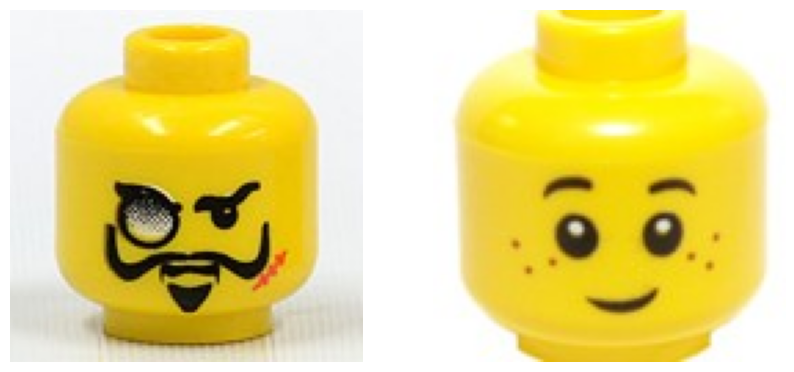

In [18]:
# Two random images
image1, _ = faces_dataset[7]
image2, _ = faces_dataset[5]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image1.permute(1, 2, 0))
axs[0].axis('off')
axs[1].imshow(image2.permute(1, 2, 0))
axs[1].axis('off')
plt.show()

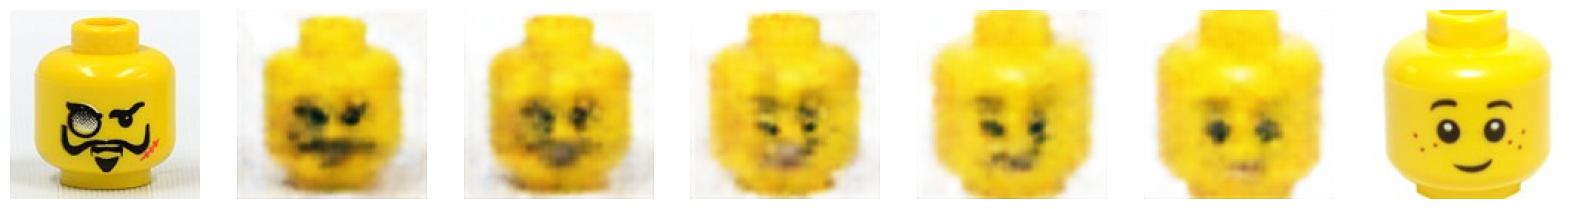

In [19]:
from utils import encode_image, interpolate

z1 = encode_image(image1, model, device)
z2 = encode_image(image2, model, device)

# Interpolation between the two images
interpolated_images = interpolate(5, z1, z2, model, device)
interpolated_images.insert(0, image1.permute(1, 2, 0).numpy())
interpolated_images.append(image2.permute(1, 2, 0).numpy())

fig, axs = plt.subplots(1, len(interpolated_images), figsize=(20, 5))
for image, ax in zip(interpolated_images, axs):
    ax.imshow(image)
    ax.axis('off')
plt.show()

In [20]:
# GIF
from PIL import Image

interpolated_images_GIF_forward = interpolate(20, z1, z2, model, device)
interpolated_images_GIF_backward = interpolate(20, z2, z1, model, device)
interpolated_images_GIF = interpolated_images_GIF_forward
interpolated_images_GIF.insert(0, image1.permute(1, 2, 0).numpy())
interpolated_images_GIF.append(image2.permute(1, 2, 0).numpy())
interpolated_images_GIF += interpolated_images_GIF_backward


interpolated_images_GIF = [Image.fromarray((image * 255).astype(np.uint8)) for image in interpolated_images_GIF]
interpolated_images_GIF[0].save('interpolated_images.gif', save_all=True, append_images=interpolated_images_GIF, duration=200, loop=0)